In [660]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from keras import regularizers
from sklearn.metrics import ConfusionMatrixDisplay,  confusion_matrix
from sklearn.preprocessing import scale

import numpy as np
import librosa
from librosa import cqt
from librosa.feature import *

from datetime import datetime
import sox
import ffmpeg
import os

#sox.file_info.file_extension('mono/Whispering - 0.wav')
#source_path='stereo'
#tfm = sox.Transformer()



## Various spectograms

In [982]:
#plt.figure(figsize=(16,16))

audio_data = 'data/music/Classical/Classical042.wav'
x , sr = librosa.load(audio_data, duration=10)

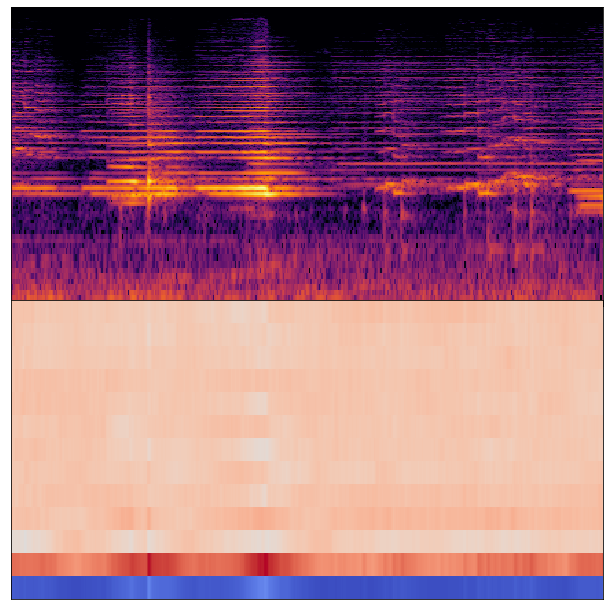

In [1000]:

fig, ax = plt.subplots(figsize=(8,8), nrows=2)

x_stft = librosa.stft(x)
ampl = librosa.amplitude_to_db(abs(x_stft))
librosa.display.specshow(ampl, sr=20500, cmap='inferno',hop_length=512, x_axis='time', y_axis='log', ax=ax[0])

mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)  # 
librosa.display.specshow(scale(mfccs), sr=sr, x_axis='time',  ax=ax[1]);

ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

fig.tight_layout(pad=-1)
fig.savefig('test.png')



#melspec = librosa.feature.melspectrogram(S=ampl, hop_length = 512, n_fft = 1024, n_mels = 64)
#ax[0].imshow(melspec);
#ax[0].specgram(scale(x), NFFT=2048, cmap='inferno');



In [601]:
#csv_file='test_feat.csv'
# create a new csv file

feat_data_lst=[]
start=datetime.now()
for i in range(25,26):
    audio_data = f'data/music/Jazz/Jazz0{str(i+1)}.wav'
    x , sr = librosa.load(audio_data, duration=10)
    feat_dic={}
# Power Based 
    for func in [rms, chroma_stft, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate]:
        feat_name=str(func).split()[1]
        feature = np.mean(func(y=x))
        feat_dic[f'{feat_name}_mean']=feature

    for func in [ mfcc, tonnetz, melspectrogram, cqt]:
        if func == tonnetz:
            feat_lst = np.mean(func(y=librosa.effects.harmonic(x), sr=sr), axis=1)
        if func == cqt:
            feat_lst = np.mean(func(y=x, sr=sr, fmin=librosa.note_to_hz('F1'), n_bins=79), axis=1)
            feat_lst = [np.real(s) for s in feat_lst]
        else:
            feat_lst = np.mean(func(y=x, sr=sr), axis=1)

        feat_name=str(func).split()[1]

        for num, feature in enumerate(feat_lst):
            feat_dic[f'{feat_name}_{num}']=feature
            
# Energy Based:
    for func in [chroma_stft, spectral_contrast ]:

        feat_lst = np.mean(func(S=np.abs(librosa.stft(x)), sr=sr), axis=1)
        feat_name=str(func).split()[1]
        for num, feature in enumerate(feat_lst):
            feat_dic[f'{feat_name}_{num}']=feature
            
            
    feat_data_lst.append(feat_dic)
            

    if(len(feat_data_lst) % 5 == 0):
        pd.DataFrame(feat_data_lst).to_csv(csv_file, mode='a', index=False, header=False)
        feat_data_lst=[]

        
print(datetime.now()-start)

0:00:01.575780


In [603]:
#feat_dic

In [604]:

#df=pd.read_csv('src/temp.csv')
df=pd.read_csv('data/features/features_temp.csv')
df.head()
#df.columns=list(feat_dic.keys())
#feat_dic['file_name']='Swing.wav'
#df.to_csv('src/test_csv.csv', mode='w')


,rms_mean,chroma_stft_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_rolloff_mean,zero_crossing_rate_mean,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,chroma_stft_10,chroma_stft_11,spectral_contrast_0,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,file_name
0,0.124413,0.342070,1782.836092,2020.991068,3845.575277,0.080111,-125.25643,120.20559,-18.326477,44.870823,...,0.625223,0.584985,16.020643,15.170582,18.914979,18.780901,19.290208,17.223859,39.243943,Blues001-0.wav
1,0.135153,0.366582,1803.933533,2044.581964,3905.403608,0.081564,-104.70713,122.28180,-16.140684,40.836025,...,0.673384,0.640099,15.873984,14.797294,17.831622,17.486506,17.602010,16.805280,40.073481,Blues001-220500.wav
2,0.130600,0.342039,1767.743609,1944.786234,3673.534477,0.087096,-113.05592,125.08429,-25.844616,44.177784,...,0.602643,0.621821,15.675862,15.249506,18.685979,18.856339,19.786168,17.509306,39.312233,Blues001-441000.wav
3,0.094325,0.357733,1364.738976,1842.867783,2976.653076,0.055211,-221.96216,131.09808,0.516326,39.070675,...,0.550234,0.647696,15.870900,17.325653,18.705041,19.633253,18.796715,17.697689,35.515755,Blues002-0.wav
4,0.087807,0.346067,1582.759409,2128.024614,3789.768808,0.052959,-222.06569,124.18471,11.235550,38.641685,...,0.502609,0.521666,16.402583,16.784014,19.222796,18.265768,17.760136,17.520428,37.559880,Blues002-220500.wav


In [605]:
stft.shape

(1025, 431)

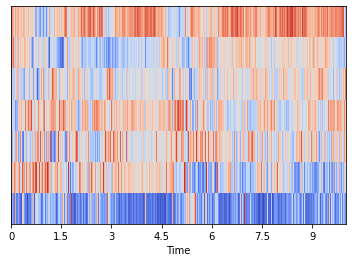

In [1001]:
contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
contrast2 = librosa.feature.spectral_contrast(y=x, sr=sr)

import librosa.display
%matplotlib inline
librosa.display.specshow(scale(contrast2), sr=sr, x_axis='time',  cmap='coolwarm')


In [607]:
y_harmonic, y_percussive = librosa.effects.hpss(x)

tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)

print('Detected Tempo: '+ str(tempo) + ' beats/min')



Detected Tempo: 107.666015625 beats/min


## cqt

In [608]:


C = librosa.cqt(y=x, sr=sr, fmin=librosa.note_to_hz('F1'), n_bins=79)

C.shape
feat_lst = np.mean(cqt(y=x, sr=sr, fmin=librosa.note_to_hz('F1'), n_bins=79), axis=1)
feat_lst=[np.real(s) for s in feat_lst]
    


### Tonetz

In [609]:

y = librosa.effects.harmonic(x)
tonnetz = librosa.feature.tonnetz(y=x, sr=sr)
tonnetz.shape


(6, 431)

In [610]:
# print(type(x), type(sr), np.shape(x))

In [611]:
import IPython.display as ipd
ipd.Audio(x)

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(x, sr=sr, ax=ax)
ax.set(title='Envelope view, mono')
ax.label_outer()

In [ ]:
X = librosa.stft(x)

Xdb = librosa.amplitude_to_db(abs(X))
#Xdb = librosa.power_to_db(np.abs(X)**2)

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

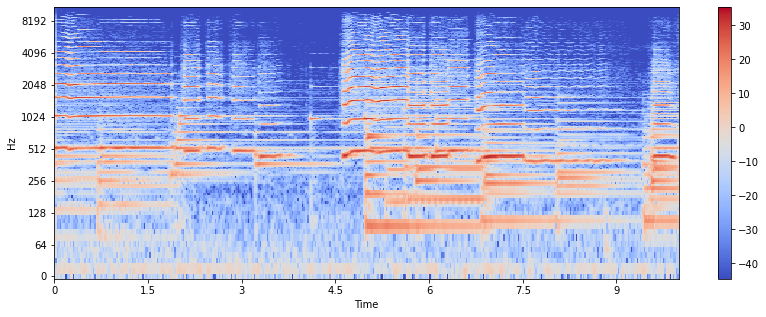

In [612]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log');
plt.colorbar();

In [613]:
# import numpy as np
# import soundfile as sf

# sr = 22050 # sample rate
# T = 5.0    # seconds
# t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
# x = 0.5*np.sin(2*np.pi*220*t)# pure sine wave at 220 Hz
# #Playing the audio
# ipd.Audio(x, rate=sr) # load a NumPy array
# #Saving the audio
# sf.write('stereo_file.wav', x, sr)
# #librosa.output.write_wav('tone_220.wav', x, sr)

### Spectral Centroid

In [614]:
from sklearn.preprocessing import minmax_scale

spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
np.shape(spectral_centroids)

(431,)

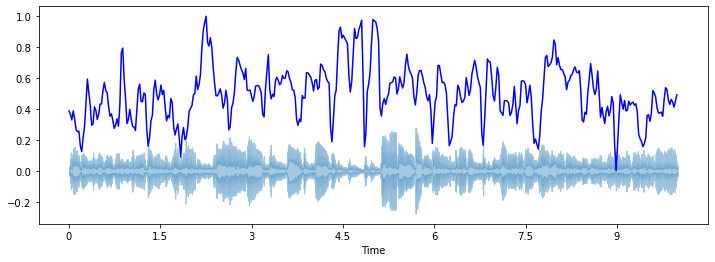

In [615]:
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids, axis=0), color='b');


### Spectral Rolloff



In [616]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sr)[0]
np.shape(spectral_rolloff)

(431,)

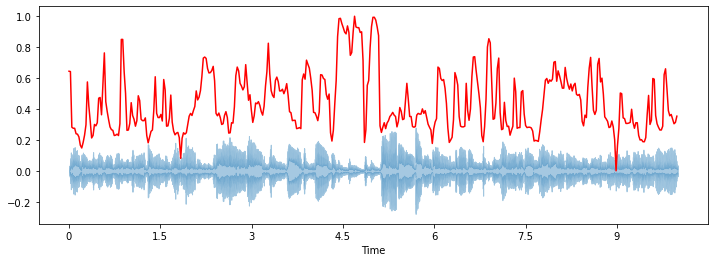

In [617]:
plt.figure(figsize=(12, 4))

librosa.display.waveshow(y=x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_rolloff, axis=0), color='r');

### Spectral Bandwidth


In [618]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr, p=4)[0]
spectral_bandwidth_2.shape

(431,)

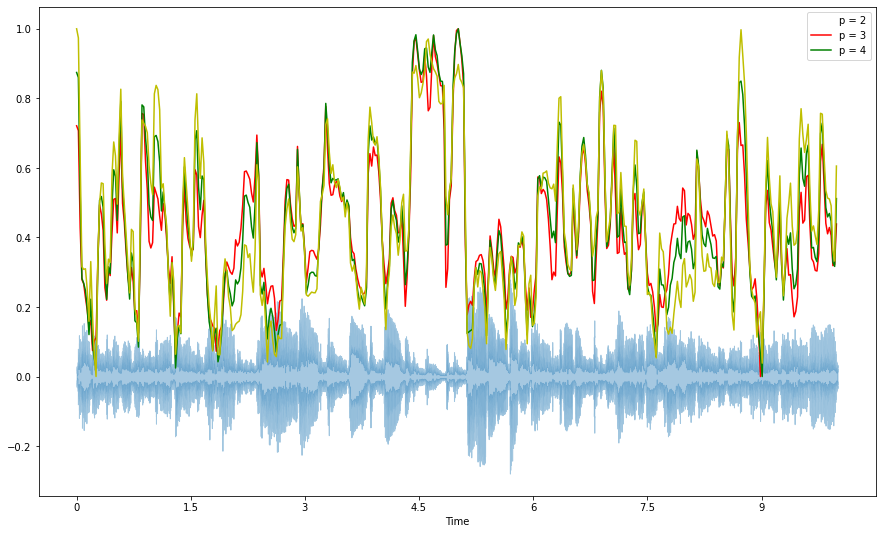

In [619]:
plt.figure(figsize=(15, 9))

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth_2), color='r')
plt.plot(t, minmax_scale(spectral_bandwidth_3), color='g')
plt.plot(t, minmax_scale(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'));

### Zero-Crossing Rate

In [623]:
n0=9100
n1=9200
zero_crossings = librosa.zero_crossings(y=x[n0:n1], pad=False)
print(sum(zero_crossings))
zero_crossings.shape

14


(100,)

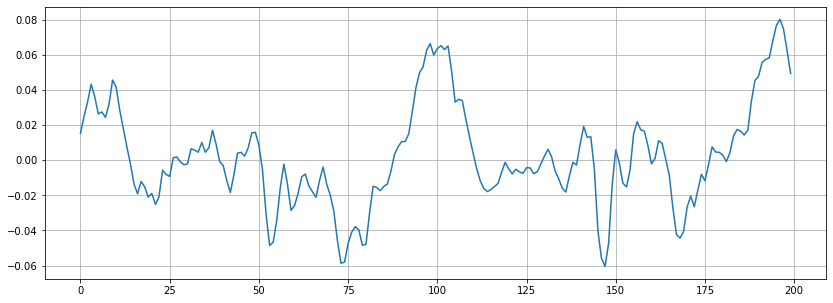

In [624]:
n0 = 9000
n1 = 9200
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

### Mel-Frequency Cepstral Coefficients(MFCCs)

In [625]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)  # n_mfcc=13
print(mfccs.shape)

(20, 431)


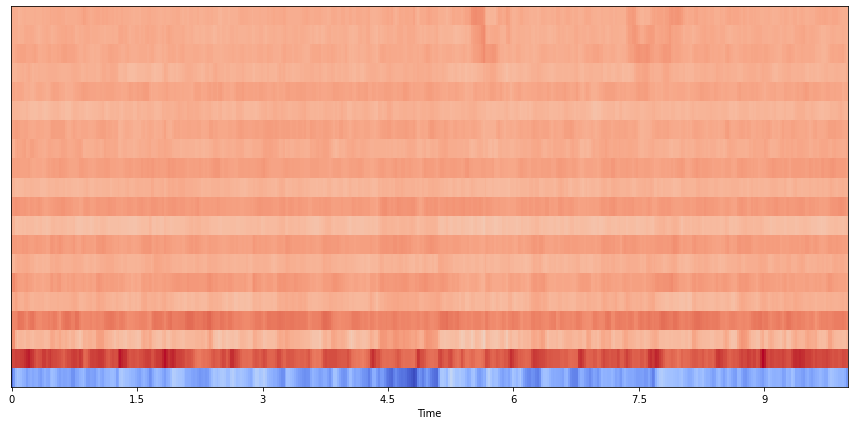

In [626]:
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time');

### Chroma feature

In [627]:
hop_length=1024

chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
np.shape(chromagram)

(12, 216)

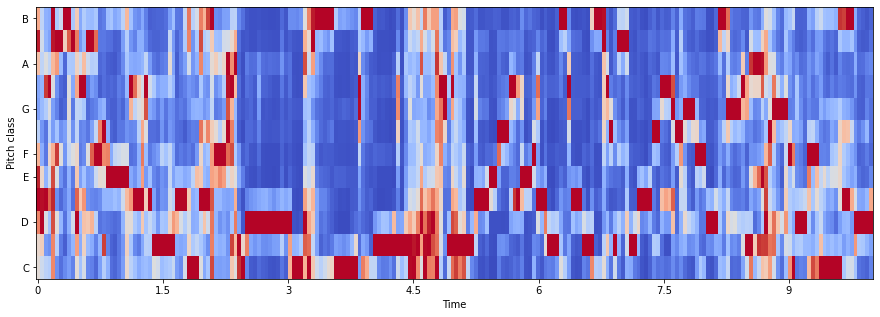

In [628]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

In [629]:
import librosa
import pandas as pd
import numpy as np

import os
from PIL import Image
import pathlib
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import keras
from keras import layers
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [630]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
music_dir='data/music'
image_dir='data/spectrogram'

mkdir(image_dir)
mkdir(music_dir)

In [631]:
# ##########################################################################################
# # Genres
# ##########################################################################################

# for base,(dirpath, dirnames, filenames) in enumerate(os.walk(music_dir)):
#     if base == 0:
#         genres=dirnames

# plt.figure(figsize=(8,8))


# ##########################################################################################
# # Header for .csv
# ##########################################################################################
# header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

# for i in range(1, 21):
#     header += f' mfcc{i}'

# header += ' label'
# header = header.split()

# file='dataset.csv'
# with open(file, 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerow(header)

# ##########################################################################################

# sr = 22050
# total_samples = 30 * sr
# num_slices = 3
# samples_per_slice = int(total_samples / num_slices)

# track_time=datetime.now()

# ##########################################################################################
# # Main Loop
# ##########################################################################################

# for genre in genres:
#     genre_path=music_dir +'/'+genre
#     image_path=image_dir+'/' + genre
#     mkdir(image_path)
#     for num,(dirpath, dirnames, filenames) in enumerate(os.walk(genre_path)):
#         for filename in filenames:
#             song_file=genre_path + '/' + filename
#             file_base=filename.split('.')[0]
#             image=image_path+ '/' + file_base + '.png'

#             y, sr = librosa.load(song_file, mono=True, duration=30)

#             for chunk in range(num_slices):
#                 start=chunk*samples_per_slice
#                 end=start+samples_per_slice
#                 ch=y[start:end]


In [632]:
for base,(dirpath, dirnames, filenames) in enumerate(os.walk(music_dir)):
    if base == 0:
        genres=dirnames



In [633]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [718]:
#feat_dic

In [635]:
import string
genres_names=df['file_name'].apply(lambda x: x.split('-')[0])
genre_names=genres_temp.apply(lambda x: x.translate(x.maketrans('', '', string.digits)) )

genre_names

0       Blues
1       Blues
2       Blues
3       Blues
4       Blues
        ...  
5599    Swing
5600    Swing
5601    Swing
5602    Swing
5603    Swing
Name: file_name, Length: 5604, dtype: object

In [652]:
X = df.drop(['file_name','mfcc_19','mfcc_18','mfcc_17','mfcc_16','mfcc_15','mfcc_14','spectral_rolloff_mean'],axis=1)
X = X.drop(['chroma_stft_0', 'chroma_stft_1',
       'chroma_stft_2', 'chroma_stft_3', 'chroma_stft_4', 'chroma_stft_5',
       'chroma_stft_6', 'chroma_stft_7', 'chroma_stft_8', 'chroma_stft_9',
       'chroma_stft_10', 'chroma_stft_11'], axis=1)
X = X[X.columns.drop(list(df.filter(regex='cqt')))]
X = X[X.columns.drop(list(df.filter(regex='tonnet')))]
X = X[X.columns.drop(list(df.filter(regex='melspec')))]



#genres = df['label']

#X = df[['chroma_stft_mean', 'rms_mean', 'mfcc_0','mfcc_1','mfcc_2','mfcc_3','mfcc_5','mfcc_4',
#       'mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12', 'zero_crossing_rate_mean']]
#genres = df['label']

encoder = LabelEncoder()
y = encoder.fit_transform(genre_names)
X.columns


Index(['rms_mean', 'chroma_stft_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'zero_crossing_rate_mean', 'mfcc_0',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'spectral_contrast_0', 'spectral_contrast_1', 'spectral_contrast_2',
       'spectral_contrast_3', 'spectral_contrast_4', 'spectral_contrast_5',
       'spectral_contrast_6'],
      dtype='object')

In [653]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(np.array(X_train, dtype = float))
X_val_scaled = scaler.transform(np.array(X_val, dtype = float))
X_test_scaled = scaler.transform(np.array(X_test, dtype = float))

In [710]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(layers.Dropout(0.2))
#model.add(BatchNormalization())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(BatchNormalization())

model.add(layers.Dense(64, activation='relu'))
#model.add(BatchNormalization())

model.add(layers.Dense(6, activation='softmax'))


In [711]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [712]:
early_stopping = [# EarlyStopping(monitor='loss', patience=25, mode='min'), 
                  ModelCheckpoint(filepath='test_model_10sec.h5', monitor='accuracy', save_best_only=True)]

In [715]:
classifier = model.fit(X_train_scaled, 
                    y_train,
                    epochs=500, 
                    batch_size=128,  callbacks=early_stopping, 
                    validation_data=(X_val_scaled, y_val))

Epoch 1/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0086 - accuracy: 0.9967 - val_loss: 0.2670 - val_accuracy: 0.9565
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0129 - accuracy: 0.9975 - val_loss: 0.2126 - val_accuracy: 0.9588
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.1990 - val_accuracy: 0.9610
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.2008 - val_accuracy: 0.9599
Epoch 5/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.2076 - val_accuracy: 0.9643
Epoch 6/500
29/29 [==============================] - 0s 7ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.2113 - val_accuracy: 0.9632
Epoch 7/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.2023 - val_accuracy: 0.9621
Epoch 8/500
2

Epoch 59/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 0.2098 - val_accuracy: 0.9621
Epoch 60/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.2075 - val_accuracy: 0.9599
Epoch 61/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.2081 - val_accuracy: 0.9643
Epoch 62/500
29/29 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2062 - val_accuracy: 0.9666
Epoch 63/500
29/29 [==============================] - 0s 7ms/step - loss: 9.2092e-04 - accuracy: 1.0000 - val_loss: 0.2091 - val_accuracy: 0.9654
Epoch 64/500
29/29 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.2108 - val_accuracy: 0.9632
Epoch 65/500
29/29 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.2105 - val_accuracy: 0.9610
Ep

29/29 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.2694 - val_accuracy: 0.9576
Epoch 117/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.2374 - val_accuracy: 0.9643
Epoch 118/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.2242 - val_accuracy: 0.9632
Epoch 119/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.2327 - val_accuracy: 0.9554
Epoch 120/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.2842 - val_accuracy: 0.9532
Epoch 121/500
29/29 [==============================] - 0s 5ms/step - loss: 9.2860e-04 - accuracy: 1.0000 - val_loss: 0.2733 - val_accuracy: 0.9543
Epoch 122/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 0.9989 - val_loss: 0.2827 - val_accuracy: 0.9543
Epoch 123

29/29 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9980 - val_loss: 0.2441 - val_accuracy: 0.9554
Epoch 174/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.2656 - val_accuracy: 0.9565
Epoch 175/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.2667 - val_accuracy: 0.9576
Epoch 176/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.2764 - val_accuracy: 0.9509
Epoch 177/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.2569 - val_accuracy: 0.9554
Epoch 178/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.2578 - val_accuracy: 0.9543
Epoch 179/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 0.9983 - val_loss: 0.2420 - val_accuracy: 0.9554
Epoch 180/500

29/29 [==============================] - 0s 5ms/step - loss: 0.0069 - accuracy: 0.9975 - val_loss: 0.3111 - val_accuracy: 0.9465
Epoch 231/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.3152 - val_accuracy: 0.9454
Epoch 232/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.2818 - val_accuracy: 0.9554
Epoch 233/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 0.9989 - val_loss: 0.2876 - val_accuracy: 0.9509
Epoch 234/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.9983 - val_loss: 0.2736 - val_accuracy: 0.9576
Epoch 235/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9983 - val_loss: 0.2914 - val_accuracy: 0.9543
Epoch 236/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.3052 - val_accuracy: 0.9543
Epoch 237/500

29/29 [==============================] - 0s 4ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.2557 - val_accuracy: 0.9554
Epoch 288/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.2417 - val_accuracy: 0.9632
Epoch 289/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.2382 - val_accuracy: 0.9576
Epoch 290/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.2504 - val_accuracy: 0.9554
Epoch 291/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.2599 - val_accuracy: 0.9565
Epoch 292/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.9983 - val_loss: 0.2507 - val_accuracy: 0.9632
Epoch 293/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.2354 - val_accuracy: 0.9610
Epoch 294/500

29/29 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.2976 - val_accuracy: 0.9554
Epoch 345/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.2730 - val_accuracy: 0.9576
Epoch 346/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.2858 - val_accuracy: 0.9509
Epoch 347/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.9972 - val_loss: 0.3052 - val_accuracy: 0.9543
Epoch 348/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 0.2910 - val_accuracy: 0.9532
Epoch 349/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.2802 - val_accuracy: 0.9588
Epoch 350/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.3154 - val_accuracy: 0.9476
Epoch 351/500

29/29 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.2327 - val_accuracy: 0.9632
Epoch 402/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.2129 - val_accuracy: 0.9699
Epoch 403/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.2035 - val_accuracy: 0.9643
Epoch 404/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.2128 - val_accuracy: 0.9677
Epoch 405/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.2263 - val_accuracy: 0.9643
Epoch 406/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.2082 - val_accuracy: 0.9654
Epoch 407/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 0.2140 - val_accuracy: 0.9643
Epoch 408/500

29/29 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.2262 - val_accuracy: 0.9610
Epoch 459/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.2570 - val_accuracy: 0.9610
Epoch 460/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.2497 - val_accuracy: 0.9576
Epoch 461/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0128 - accuracy: 0.9978 - val_loss: 0.2798 - val_accuracy: 0.9498
Epoch 462/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.2823 - val_accuracy: 0.9532
Epoch 463/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.2755 - val_accuracy: 0.9532
Epoch 464/500
29/29 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.2917 - val_accuracy: 0.9554
Epoch 465/500

In [716]:
score_test = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing Accuracy: ", score_test[1])
print("Testing Cross Entropy: %.2f" % score_test[0])

score_test = model.evaluate(X_val_scaled, y_val, verbose=0)
print("Val Accuracy: ", score_test[1])
print("Val Cross Entropy: %.2f" % score_test[0])

Testing Accuracy:  0.9652096629142761
Testing Cross Entropy: 0.18
Val Accuracy:  0.958751380443573
Val Cross Entropy: 0.24


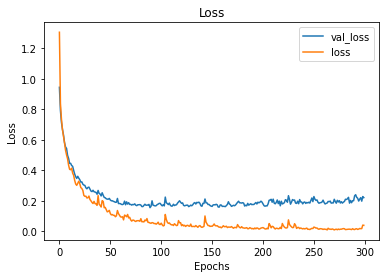

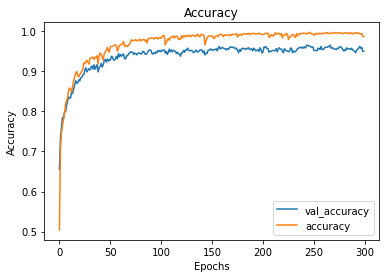

In [709]:
visualize_training_results(classifier)

In [680]:
y_hat=model.predict(X_test_scaled)
y_pred=np.argmax(y_hat, axis=1)

In [681]:
genres

['Blues', 'Classical', 'Jazz', 'JazzPiano', 'Rock', 'Swing']

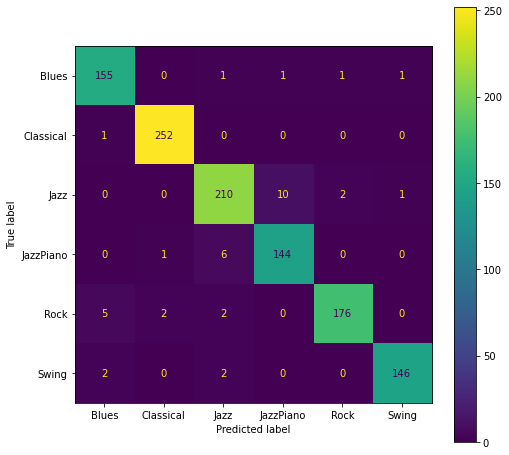

In [717]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=genres, ax=ax)

In [1078]:
genre_names

['Blues', 'Classical', 'Jazz', 'JazzPiano', 'Rock', 'Swing']

<AxesSubplot:>

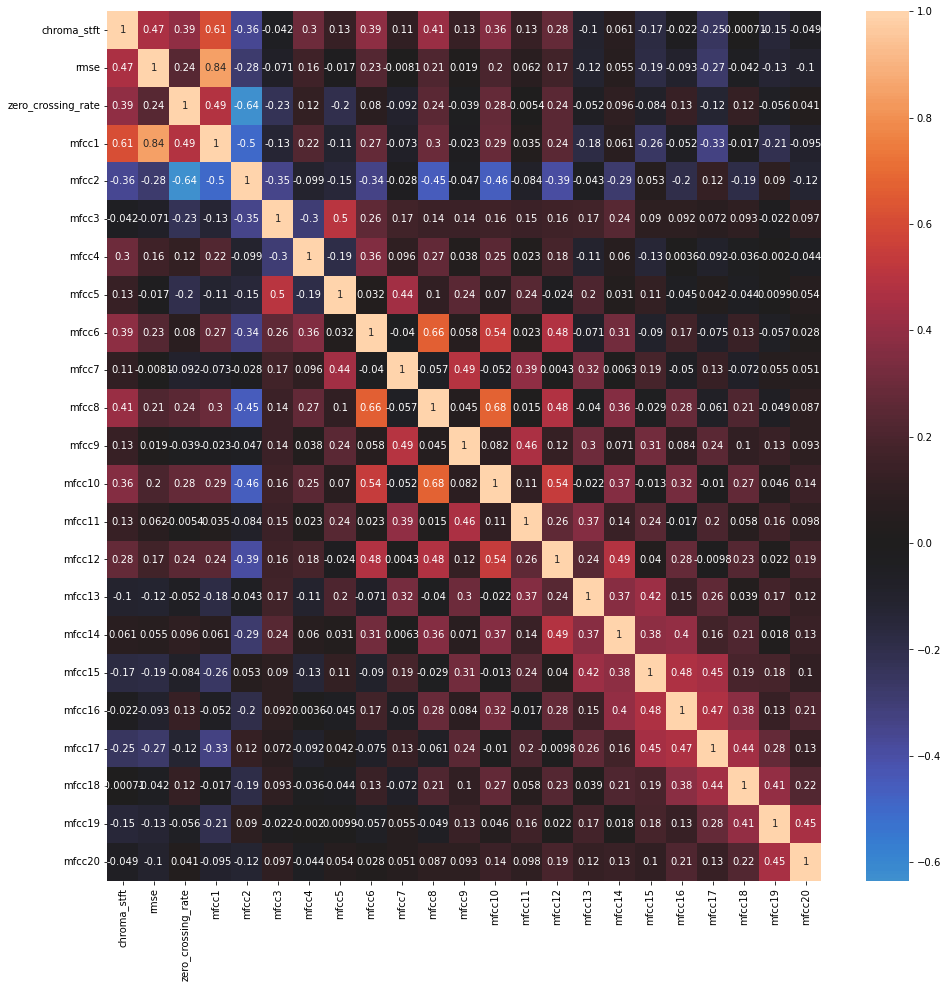

In [1079]:
fig, ax = plt.subplots(figsize=(16,16))
import seaborn as sns

sns.heatmap(X.drop(['rolloff','spectral_bandwidth','spectral_centroid'],axis=1).corr(), annot=True, center=0, ax=ax )

In [1392]:
df=pd.read_csv('src/test_csv.csv')

df

,0.12441264,0.3420697,1782.8360915194967,2020.9910679251227,3845.5752768815255,0.08011097919083526,-125.25643,120.20559,-18.326477,44.870823,...,0.6087576,0.6252231,0.5849849,16.020643471554287,15.170581911901026,18.914978555265296,18.78090079194039,19.290208082468297,17.22385924742675,39.24394288808388
0,0.135153,0.366582,1803.933533,2044.581964,3905.403608,0.081564,-104.70713,122.281800,-16.140684,40.836025,...,0.611369,0.673384,0.640099,15.873984,14.797294,17.831622,17.486506,17.602010,16.805280,40.073481
1,0.130600,0.342039,1767.743609,1944.786234,3673.534477,0.087096,-113.05592,125.084290,-25.844616,44.177784,...,0.568999,0.602643,0.621821,15.675862,15.249506,18.685979,18.856339,19.786168,17.509306,39.312233
2,0.094325,0.357733,1364.738976,1842.867783,2976.653076,0.055211,-221.96216,131.098080,0.516326,39.070675,...,0.523479,0.550234,0.647696,15.870900,17.325653,18.705041,19.633253,18.796715,17.697689,35.515755
3,0.087807,0.346067,1582.759409,2128.024614,3789.768808,0.052959,-222.06569,124.184710,11.235550,38.641685,...,0.481474,0.502609,0.521666,16.402583,16.784014,19.222796,18.265768,17.760136,17.520428,37.559880
4,0.105196,0.315515,1645.204582,2149.623395,3890.540202,0.059678,-182.56636,122.231735,9.720888,34.887306,...,0.480544,0.527651,0.551702,15.928384,16.904601,19.804583,19.596706,18.244592,17.260199,39.064416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0.025393,0.215803,1568.371889,1514.923375,2848.902727,0.092441,-378.46063,121.106895,-22.530333,28.277319,...,0.300332,0.241046,0.353950,18.113422,17.146781,24.685800,26.262957,25.033326,23.254171,28.431838
720,0.038749,0.256419,1249.345250,1373.017368,2348.293225,0.074031,-318.66590,155.912000,-23.440546,31.503601,...,0.409043,0.286306,0.446881,19.556937,18.599428,22.592381,24.486453,24.669927,23.044956,29.181401
721,0.034092,0.229285,1492.421315,1500.631709,2788.200077,0.078644,-310.53050,132.400630,-40.955370,27.352670,...,0.429022,0.287999,0.512352,18.084445,19.111468,23.608904,22.677301,23.160222,22.908838,30.741401
722,0.036719,0.228131,1326.987013,1420.579118,2505.370697,0.071400,-307.37717,146.211010,-34.626305,29.709652,...,0.462177,0.267248,0.480226,19.073028,21.231900,24.317302,23.315806,23.257983,22.910811,29.993994


In [1393]:
!pwd


/c/DataScience/Flatiron/Projects/playground/Audio
